In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras.layers as layers
from tensorflow.keras.applications import EfficientNetB7
from google.colab import drive as google


In [ ]:
google.mount("/content/Drive")

Mounted at /content/Drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Attention Gate
def attention_block(x, g, inter_channels):
    theta_x = layers.Conv2D(inter_channels, 1, strides=1, padding='same')(x)
    phi_g = layers.Conv2D(inter_channels, 1, strides=1, padding='same')(g)
    add = layers.Add()([theta_x, phi_g])
    act = layers.Activation('relu')(add)
    psi = layers.Conv2D(1, 1, strides=1, padding='same', activation='sigmoid')(act)
    return layers.Multiply()([x, psi])

# U-Net with Attention for Classification
def unet_attention(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)

    # Decoder with Attention Blocks
    up3 = layers.Conv2DTranspose(256, kernel_size=2, strides=2, padding="same")(conv4)
    att3 = attention_block(conv3, up3, 256)
    merge3 = layers.Concatenate()([att3, up3])
    conv5 = layers.Conv2D(256, 3, activation="relu", padding="same")(merge3)

    up2 = layers.Conv2DTranspose(128, kernel_size=2, strides=2, padding="same")(conv5)
    att2 = attention_block(conv2, up2, 128)
    merge2 = layers.Concatenate()([att2, up2])
    conv6 = layers.Conv2D(128, 3, activation="relu", padding="same")(merge2)

    up1 = layers.Conv2DTranspose(64, kernel_size=2, strides=2, padding="same")(conv6)
    att1 = attention_block(conv1, up1, 64)
    merge1 = layers.Concatenate()([att1, up1])
    conv7 = layers.Conv2D(64, 3, activation="relu", padding="same")(merge1)


    # Classification Head
    gap = layers.GlobalAveragePooling2D()(conv7)
    output = layers.Dense(num_classes, activation='softmax')(gap)

    model = keras.Model(inputs, output)
    return model


In [ ]:
# Define model
input_shape = (256, 256, 3)  # Adjust size based on your MRI dataset
num_classes = 4  # (3 tumor types + 1 no tumor)
model = unet_attention(input_shape, num_classes)

# Compile model
model.compile(optimizer='adam',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Data loading and augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

In [ ]:
import zipfile
import os

def unzip_file(zip_path, extract_to='.'):
    """
    Unzips a file to the specified directory.

    Parameters:
    zip_path (str): Path to the zip file.
    extract_to (str): Directory where the files should be extracted. Default is the current directory.
    """
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Extracted files to: {os.path.abspath(extract_to)}")
    except Exception as e:
        print(f"Error: {e}")

# Example usage
unzip_file('/content/Drive/MyDrive/brain tumor.zip', '/content/braintumor_folder')


Extracted files to: /content/braintumor_folder


In [ ]:
IMG_SIZE = 256
TRAIN_DIR = "/content/braintumor_folder/Training"
TEST_DIR = "/content/braintumor_folder/Testing"

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


training_dataset = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size = (IMG_SIZE,IMG_SIZE),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = True
)
test_datagen = ImageDataGenerator(rescale=1./255)

test_dataset = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size = (IMG_SIZE,IMG_SIZE),
    batch_size = 32,
    class_mode = "categorical"
)

training_dataset.class_indices



Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

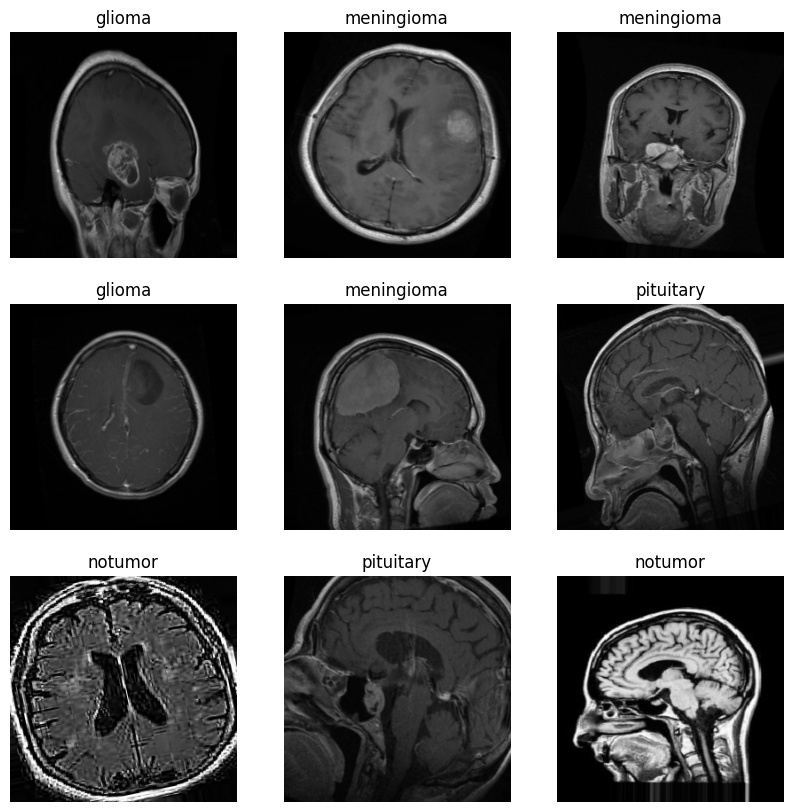

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels
images, labels = next(training_dataset)  # Get one batch (32 images in this case)

# Get class names from class indices
class_labels = {v: k for k, v in training_dataset.class_indices.items()}  # Reverse the dictionary

plt.figure(figsize=(10, 10))
for i in range(9):  # Show 9 images
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])  # Images are already rescaled
    label_index = np.argmax(labels[i])  # Get the class index
    plt.title(class_labels[label_index])  # Show class name
    plt.axis("off")

plt.show()


In [ ]:
from tensorflow.keras.callbacks import Callback
class StopOnAccuracy(Callback):
  def __init__(self,target_acc=0.98):
    super(StopOnAccuracy, self).__init__()
    self.target_acc = target_acc

  def on_epoch_end(self, epoch, logs=None):
    logs = logs or {}
    if logs.get('accuracy')>=self.target_acc:
      print(f"\nReached {self.target_acc} , so the training is being stopped\n")
      self.model.stop_training = True

stop_on_accuracy = StopOnAccuracy(target_acc=0.96)

from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience= 15, monitor="val_loss", restore_best_weights = True, verbose = 1)


In [ ]:
print(model.to_json())  # Useful for saving/loading architecture


{"module": "keras.src.models.functional", "class_name": "Functional", "config": {"name": "functional_1", "trainable": true, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_shape": [null, 256, 256, 3], "dtype": "float32", "sparse": false, "name": "input_layer_1"}, "registered_name": null, "name": "input_layer_1", "inbound_nodes": []}, {"module": "keras.layers", "class_name": "Conv2D", "config": {"name": "conv2d_20", "trainable": true, "dtype": {"module": "keras", "class_name": "DTypePolicy", "config": {"name": "float32"}, "registered_name": null}, "filters": 64, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": "Zeros", "config": {

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_20[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 128, 128, 64)   │              0 │ conv2d_21[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ conv2d_22[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 64, 64, 128)    │              0 │ conv2d_23[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 32, 32, 256)    │              0 │ conv2d_25[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_26[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 64, 64, 256)    │        524,544 │ conv2d_27[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 64, 64, 256)    │         65,792 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 64, 64, 256)    │         65,792 │ conv2d_transpose[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_3 (Add)               │ (None, 64, 64, 256)    │              0 │ conv2d_28[0][0],       │
│                           │                        │                │ conv2d_29[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activat

 Total params: 7,096,327 (27.07 MB)

 Trainable params: 7,096,327 (27.07 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
tf.keras.utils.plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


In [ ]:
history = model.fit(
    training_dataset,
    epochs = 100,
    validation_data = test_dataset,
    batch_size = 32,
    validation_steps = int(0.25*len(test_dataset)),
    callbacks = [stop_on_accuracy,early_stopping,tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3737 - loss: 1.2539

179/179 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - accuracy: 0.3744 - loss: 1.2532 - val_accuracy: 0.5281 - val_loss: 1.1329
Epoch 2/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.6066 - loss: 0.9286 - val_accuracy: 0.4375 - val_loss: 1.7691
Epoch 3/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6390 - loss: 0.9312

179/179 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.6389 - loss: 0.9318 - val_accuracy: 0.5781 - val_loss: 1.0752
Epoch 4/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6055 - loss: 0.9505

179/179 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.6057 - loss: 0.9503 - val_accuracy: 0.6969 - val_loss: 0.9852
Epoch 5/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6764 - loss: 0.8240

179/179 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.6764 - loss: 0.8239 - val_accuracy: 0.6938 - val_loss: 0.9698
Epoch 6/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7052 - loss: 0.7534

179/179 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.7052 - loss: 0.7533 - val_accuracy: 0.7125 - val_loss: 0.8922
Epoch 7/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.6926 - loss: 0.7419 - val_accuracy: 0.7000 - val_loss: 0.9599
Epoch 8/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7343 - loss: 0.6947

179/179 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.7342 - loss: 0.6948 - val_accuracy: 0.7188 - val_loss: 0.8253
Epoch 9/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 321s 1s/step - accuracy: 0.7324 - loss: 0.6840 - val_accuracy: 0.6781 - val_loss: 0.9492
Epoch 10/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.7307 - loss: 0.6921 - val_accuracy: 0.7344 - val_loss: 0.8416
Epoch 11/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7222 - loss: 0.6908

179/179 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.7223 - loss: 0.6907 - val_accuracy: 0.7312 - val_loss: 0.7707
Epoch 12/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7509 - loss: 0.6464

179/179 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.7509 - loss: 0.6464 - val_accuracy: 0.7031 - val_loss: 0.7372
Epoch 13/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7900 - loss: 0.5602

179/179 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.7899 - loss: 0.5604 - val_accuracy: 0.7500 - val_loss: 0.6724
Epoch 14/100
 49/179 ━━━━━━━━━━━━━━━━━━━━ 2:24 1s/step - accuracy: 0.7613 - loss: 0.5914

In [ ]:
model.save("/content/Drive/MyDrive/finalfinalp2.h5")

In [ ]:
  import matplotlib.pyplot as plt

train_acc = history.history["accuracy"]
test_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs_range = range(1,19)

plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.plot(epochs_range,train_acc,label="Training Accuracy",marker="o")
plt.plot(epochs_range,test_acc,label="Validation Accuracy",marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training v/s Validation Accuracy")
plt.legend()
plt.grid()

plt.figure(figsize=(18,5))
plt.subplot(1,2,2)
plt.plot(epochs_range,loss,label = "Training_loss",marker="o")
plt.plot(epochs_range,val_loss, label="Validation_loss",marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training v/s Validation loss")
plt.legend()
plt.grid()

plt.show()

